In [ ]:
#Installing Yfinace or Yahoo Finance to download data
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.3 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
# Standard Imports
import numpy as np
import pandas as pd
import statsmodels
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import coint   
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime
from functools import cmp_to_key
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

Downloading the dataset from Yahoo Finance to do the Time series analysis 

In [ ]:
def downloadStockData(tickers,start,end):
    """
        This function downloads the Closing price of the stock and creates a  Panda dataframe from it
        Params:
            tickers : a list of ticker of various stocks
            start   : it is the start date of the data to be downloaded. It is a datetime in datetime format.
            end     : it is the end date of the data to be downloaded. It is a datetime in datetime format.

        Return:
            A dataframe with all the close for of each stock on each open market day
    """
    ticker_data = yf.download(tickers, start, end)['Adj Close']
    return ticker_data

In [ ]:
tickers = ['HD', 'DIS','MSFT', 'BA', 'MMM', 'PFE', 'NKE', 'JNJ', 'MCD', 'XOM', 'GS', 'JPM', 'AXP', 'V', 'IBM', 'UNH', 'PG', 'GE', 'KO', 'CSCO', 'CVX', 'CAT', 'MRK', 'WMT', 'VZ', 'RTX', 'TRV', 'AAPL', 'ADBE', 'EBAY', 'QCOM', 'HPQ', 'JNPR', 'AMD']#list of stock prices
start = datetime.datetime(2014,1,1)#starting date
end = datetime.datetime(2020,1,1)#closing date
data = downloadStockData(tickers,start,end)
data.head()

[*********************100%***********************]  34 of 34 completed


,AAPL,ADBE,AMD,AXP,BA,CAT,CSCO,CVX,DIS,EBAY,...,PFE,PG,QCOM,RTX,TRV,UNH,V,VZ,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-02,17.415533,59.290001,3.95,78.466019,116.807953,69.512550,16.717548,85.449905,70.192520,21.509682,...,20.879053,61.941525,56.562595,57.451054,72.912949,65.163658,52.048119,32.481434,64.995560,67.634827
2014-01-03,17.032976,59.160000,4.00,78.720436,117.619850,69.473869,16.702356,85.594437,70.045258,21.238516,...,20.920181,61.872314,56.230888,57.660458,72.774193,65.626808,52.083431,32.096958,64.781418,67.472099
2014-01-06,17.125870,58.119999,4.13,78.685318,118.295120,68.561172,16.725147,85.367310,69.778374,20.648335,...,20.940746,62.018417,56.084309,57.604252,72.578308,64.875259,51.770229,32.275932,64.418999,67.573807
2014-01-07,17.003391,58.970001,4.18,78.387085,120.089905,68.785477,16.953115,86.090057,70.256943,21.082996,...,21.070982,62.618313,56.500893,57.972000,72.153877,66.858932,52.165859,32.680302,64.616669,68.529846
2014-01-08,17.111069,58.900002,4.18,78.633347,120.354874,68.947891,16.937918,84.864799,69.226181,20.883610,...,21.214930,61.710812,56.840324,58.043491,71.484543,66.081230,52.333069,32.499374,64.106010,68.306084


In [ ]:
def findCointegrationValue(data,threshold=0.01):
    """
        This function find out the pairs of stock with p value less than a constant
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            p values of all the pairs , the list of all the pairs with p value less than the threshold 
    """
    n = data.shape[1]# number of days present
    p_values_matrix = np.ones((n,n));
    keys = data.keys();
    pairs = []
    for i in range(n):
      for j in range(i+1,n):
        S1 = data[keys[i]]
        S2 = data[keys[j]]
        result = coint(S1,S2)#function to cointegrate the stocks
        pvalue = result[1]
        p_values_matrix[i,j]=pvalue
        if(pvalue <threshold):
          pairs.append(((i,j),pvalue))#It follows Alternate hypothesis, hence the stocks are cointegrated  
        
    return p_values_matrix,pairs 

In [ ]:
def compare(x,y):
  return x[1]-y[1]

#Normalising the data
def zscore(series): 
    newSeries = series.copy()
    for i in range(len(newSeries)):
        x = (newSeries[i] - newSeries[:i+1].mean()) / np.std(newSeries[:i+1])
        series[i]= x
    return series

In [ ]:

def getBestKStocks(data,k=10,p_value_threshold=0.05):
    """
        This functions find out the k pairs with the least p value and all of them should be less than the threshold  
        Params:
            data               : the dataframe containning all the close for of each stock on each open market day
            k                  : the number of pairs to be found out
            p_value_threshold  : the threshold value for the p value of pairs of stocks. We consider a 2 stocks to be cointegrted only if the p value is less than this value

        Returns:
            the p value for all the pairs of stocks , the list k pairs with the least p value and their p values . If k such pairs doesn't exists return how many of them occur 
    """
    p_values_matrix, pairs = findCointegrationValue(data)
    tem=sorted(pairs,key=cmp_to_key(compare))
    if len(tem) < k:
      return p_values_matrix,tem
    return p_values_matrix,tem[0:k]


In [ ]:
_, cointegrated_pair = getBestKStocks(data,10)
keys  = data.keys()

In [ ]:
cmp1 = keys[cointegrated_pair[0][0][0]]
cmp2 = keys[cointegrated_pair[0][0][1]]
print(f"Pairs having the highest cointegration value/least p value are {cmp1} and {cmp2}.")

Pairs having the highest cointegration value/least p value are AMD and MRK.


In [ ]:
print(cointegrated_pair)

[((2, 21), 0.0029484657723636795), ((18, 31), 0.006296277598339756), ((27, 32), 0.008322966521355762)]


**CALCULATING THE SPREAD**

Here we are calculating the spread of two most correlated stocks in our dataset

AMD MRK
red is the mean line


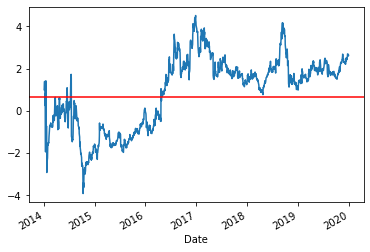

In [ ]:
S1= "AMD"
S2= "MRK"
ratios = data[S1]/data[S2]
print(S1,S2)
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="red")
print("red is the mean line")
plt.show()

Ploting them over the timeline

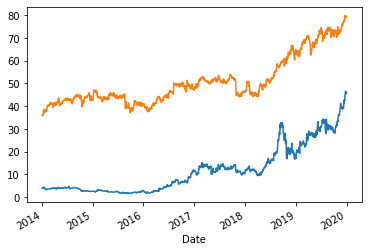

In [ ]:
data[S1].plot()
data[S2].plot()

EBAY PFE


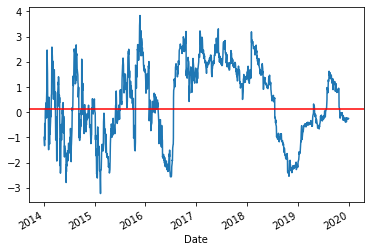

In [ ]:
S1= "EBAY"
S2= "PFE"
ratios = data[S1]/data[S2]
print(S1,S2)
zscore(ratios).plot()
plt.axhline(zscore(ratios).mean(),color="red")
plt.show()

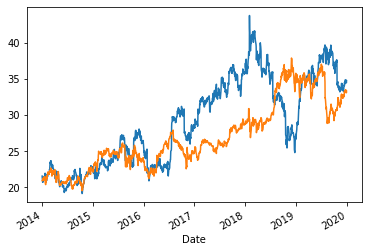

In [ ]:
data[S1].plot()
data[S2].plot()

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

60 day Moving Average of Ratio
5 day Moving Average of Ratio
60 day Standard Deviation
z score or normalised score

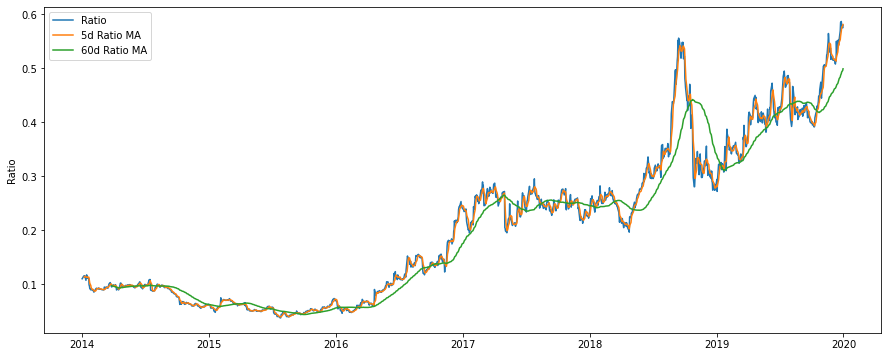

In [ ]:
S1= "AMD"
S2= "MRK"
ratios = data[S1]/data[S2]
ratios_mavg5 = ratios.rolling(window=5, center=False).mean()
ratios_mavg60 = ratios.rolling(window=60, center=False).mean()
std_60 = ratios.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15, 6))
plt.plot(ratios.index, ratios.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

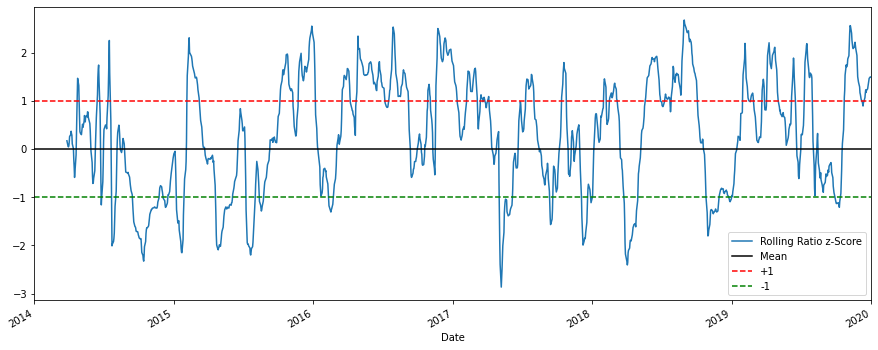

In [ ]:
plt.figure(figsize=(15,6))
zscore_60_5.plot()
plt.xlim('2014', '2020')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

**Creating a Strategy**


A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:
*   Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.

*   Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.


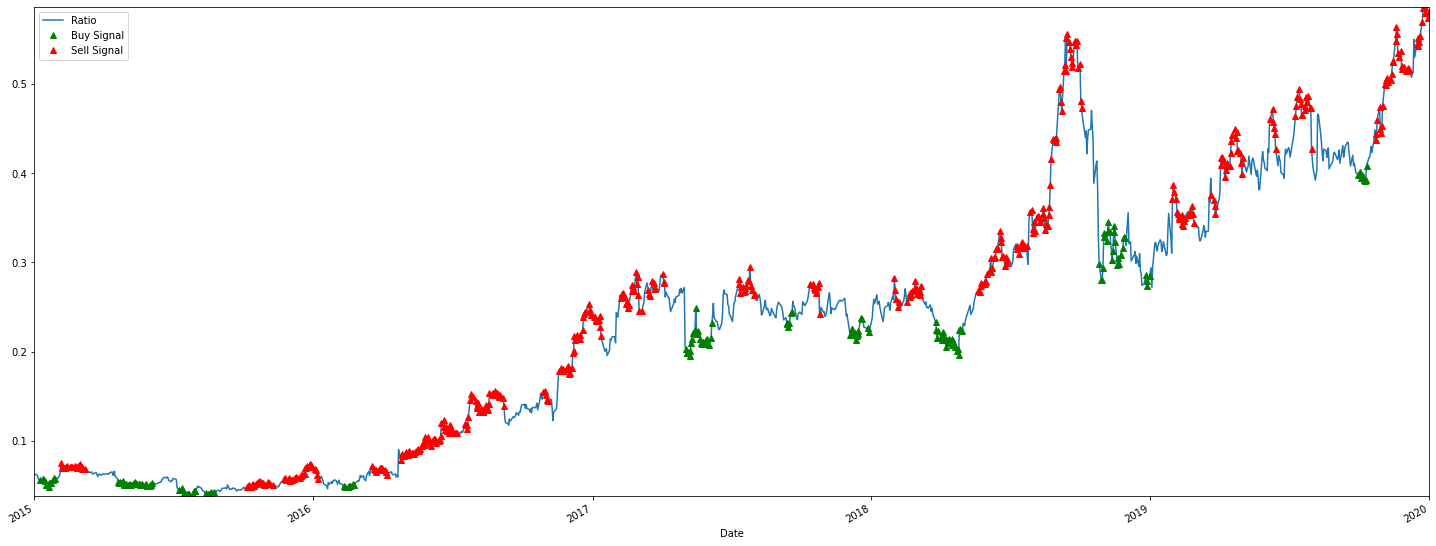

In [ ]:
plt.figure(figsize=(25,10))

ratios[160:].plot()
buy = ratios.copy()
sell = ratios.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2015','2020')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

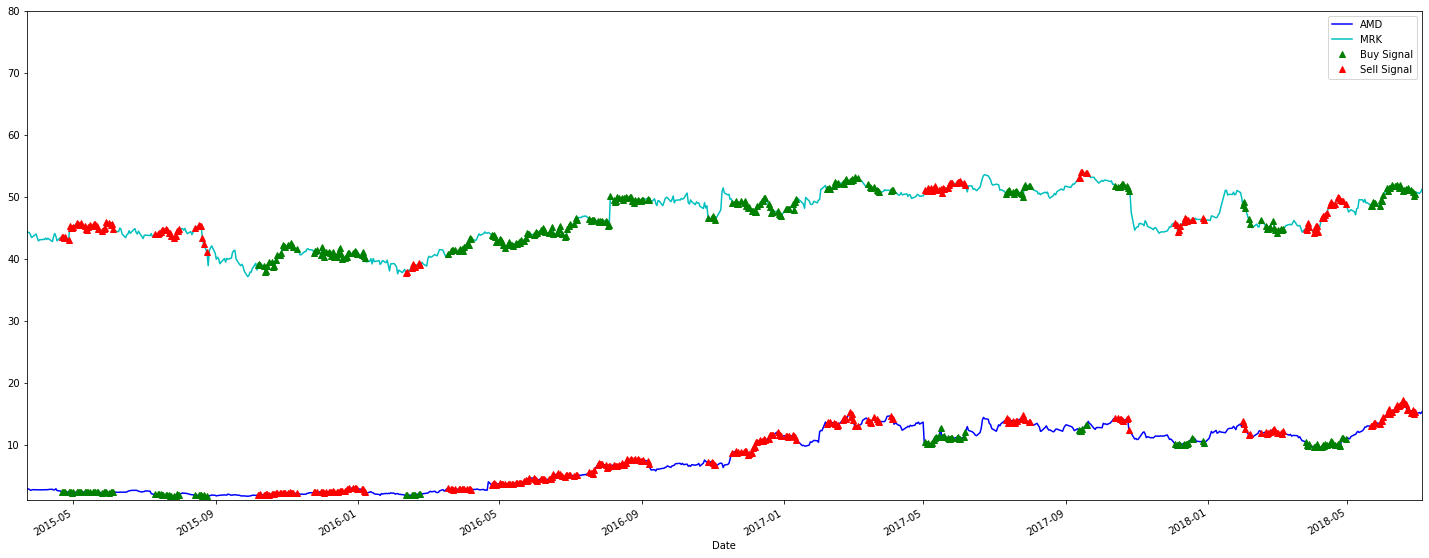

In [ ]:
plt.figure(figsize=(25,10))
S1 = data['AMD']
S2 = data['MRK']

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(1, 80)
plt.xlim('2015-03-22', '2018-07-04')

plt.legend(['AMD', 'MRK', 'Buy Signal', 'Sell Signal'])
plt.show()

**Trading Strategy**

For the cointegration approach, we will use the moving averages to calculate the transactions to be done.
First of all we calculate the moving average on window size of window1(or short window) and window2(long window) and the moving standard deviation for window size of window2 for the ratio(Y/X) of stocks.
            Also we assume window1
Now when moving_average_window1 > moving_average_window2 + c1 * standard_deviation_window2 , we then short the stock Y and go for long on stock X and we would square off when
            moving_average_window1 < moving_average_window2 - c2 * standard_deviation_window2

In [ ]:
def trade(stock1, stock2, window1=5, window2=60,MAX_SHORTING_AMOUNT=10000, MAX_TRANSACTION_AT_A_TIME=5,c1=1,c2=0.75):
    """
    Params:
            data1                     : Time series data of stock 1
            data2                     : Time series data of stock 2
            window1                   : The size of the data points from which we calculate the moving averages. This will be the less number of days moving average
            window1                   : The size of the data points from which we calculate the moving averages. This will be the more number of days moving average
            MAX_SHORTING_AMOUNT       : The maximum amount of money , for which the stocks can be shorted at a time
            MAX_TRANSACTION_AT_A_TIME : the number of times we can short a stock , in each shorting we do the shorting worth  MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
    """
    #Computing the ratio over time
    ratios = stock1/stock2 
    # Compute rolling mean and rolling standard deviation
    ma1 = ratios.rolling(window=window1,center=False).mean()
    ma2 = ratios.rolling(window=window2,center=False).mean()
    std2 = ratios.rolling(window=window2,center=False).std()
    
    #initialising the money,number of transactions,number of stock1, stock2
    money=0
    stock1_count = 0
    stock2_count = 0
    num_of_trans = 0
    for i in range(window2-1,len(ratios)):
        if ma1[i] > (ma2[i]+c1*std2[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            stock1_count -= amount/stock1[i] 
            stock2_count += amount/stock2[i]
        elif ma1[i] < (ma2[i] - c1*std2[i]) and num_of_trans <= MAX_TRANSACTION_AT_A_TIME :  
            num_of_trans +=1
            amount = MAX_SHORTING_AMOUNT/MAX_TRANSACTION_AT_A_TIME
            stock1_count += amount/stock1[i] 
            stock2_count -= amount/stock2[i]
        elif ma1[i] <= ma2[i]+c2*std2[i] and ma1[i] >= ma2[i]-c2*std2[i]:
            money += stock1[i] * stock1_count + stock2[i] * stock2_count
            stock1_count = 0
            stock2_count = 0
            num_of_trans = 0

    #Squaring off all transactions
    money += stock1[len(ratios)-1] * stock1_count + stock2[len(ratios)-1] * stock2_count

    return money

In [ ]:
cointegraed_tickers = ['AMD','MRK']
start = datetime.datetime(2020,1,1)
end = datetime.datetime(2022,1,1)
recent_cointegrated_data = downloadStockData(cointegraed_tickers,start,end)

[*********************100%***********************]  2 of 2 completed


In [ ]:
print("Net gain: ",trade(recent_cointegrated_data['AMD'],recent_cointegrated_data['MRK']))

Net gain:  1195.8271618368349
